# Feature Engineering

In [2]:
import os
import pandas as pd
import numpy as np
os.chdir('/Users/beth/Documents/Metis/metis_project_3/clinical_trials')

## Basic Info

In [334]:
comp_basic_info = pd.read_csv('All_BasicInfo_' + str(1) + '.csv', quotechar='"',skiprows=10,header=0)
for i in range(2,20):
    df = pd.read_csv('All_BasicInfo_' + str(i) + '.csv', quotechar='"',skiprows=10,header=0)
    comp_basic_info = pd.concat([comp_basic_info, df], axis=0, ignore_index=True)

In [337]:
comp_basic_info.to_csv('All_BasicInfo_combined.csv')

In [306]:
comp_basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18125 entries, 0 to 18124
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   18125 non-null  int64 
 1   NCTId                  18125 non-null  object
 2   BriefTitle             18125 non-null  object
 3   Condition              18125 non-null  object
 4   Keyword                13545 non-null  object
 5   OverallStatus          18125 non-null  object
 6   WhyStopped             3224 non-null   object
 7   StartDate              17964 non-null  object
 8   PrimaryCompletionDate  16668 non-null  object
 9   CompletionDate         16736 non-null  object
 10  ReferencePMID          6925 non-null   object
 11  ReferenceType          7140 non-null   object
 12  IsFDARegulatedDrug     1892 non-null   object
 13  IsFDARegulatedDevice   1887 non-null   object
 14  IsUnapprovedDevice     6 non-null      object
 15  HasExpandedAccess  

In [307]:
comp_basic_info.drop(['ReferencePMID','ReferenceType','IsUnapprovedDevice','IsUSExport'],axis=1,inplace=True)

In [308]:
comp_basic_info['IsFDARegulatedDrug'].value_counts()

Yes    1378
No      514
Name: IsFDARegulatedDrug, dtype: int64

### Wordclouds to find common words in free text entries

In [6]:
from wordcloud import WordCloud, STOPWORDS 

In [7]:
import re

In [8]:
condition_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in comp_basic_info['Condition']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = re.split('\|',val)
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    condition_words += " ".join(tokens)+" "

In [9]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(condition_words) 

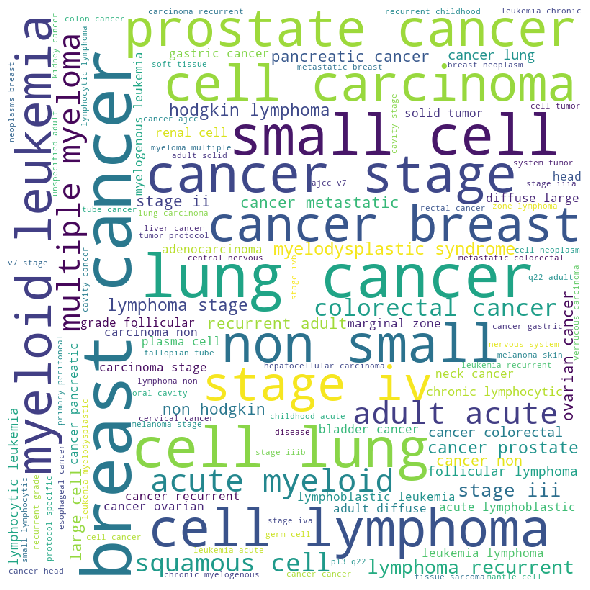

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [11]:
keyword_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in comp_basic_info['Keyword']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = re.split('\|',val)
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    keyword_words += " ".join(tokens)+" "

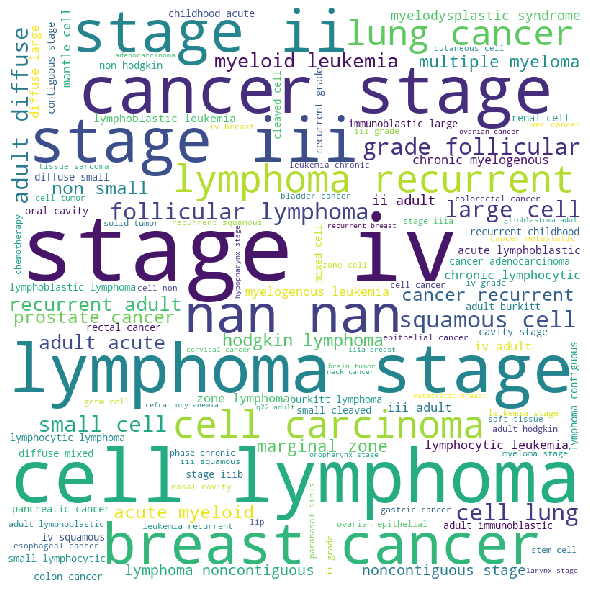

In [12]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(keyword_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Selected top words and synonyms from word clouds as new features

In [309]:
top_words = [' ii ', 'iii', 'iv', 'breast', 'lymphoma', 'non-hodgkin/non hodgkin', 'noncontiguous', 'prostate', \
        'lung', 'myeloma', 'leukemia', 'gastric', 'liver/hepato', 'colorectal/colon', 'cervical', 'pancreatic', \
        'renal', 'melanoma', 'non small/large cell', 'small cell', 'squamous', 'diffuse', 'childhood', 'recurrent', \
        'metastatic', 'diffuse', 'acute', 'triple negative/triple-negative']

In [310]:
comp_basic_info['Condition']=comp_basic_info['Condition'].astype(str)
comp_basic_info['Keyword']=comp_basic_info['Keyword'].astype(str)

In [311]:
top_words_dict={}
for i in top_words:
    if "/" in i:
        j = i.split("/")
        top_words_dict[i] = comp_basic_info['Condition'].apply(lambda x: j[0] in x.lower() or j[1] in x.lower()) | \
     comp_basic_info['Keyword'].apply(lambda x: j[0] in x.lower() or j[1] in x.lower())
    else:
        top_words_dict[i] = comp_basic_info['Condition'].apply(lambda x: i in x.lower()) | \
     comp_basic_info['Keyword'].apply(lambda x: i in x.lower())

In [312]:
top_words_df = pd.DataFrame(top_words_dict)

In [314]:
comp_basic_info = pd.concat([comp_basic_info, top_words_df],axis=1)

WhyStopped - not used in model, just curious about distribution and if it would be useful for sperating Terminated class into more classes

In [315]:
comp_basic_info['WhyStopped']

0                                              low accrual
1                 Patients' enrollment was not sufficient.
2        STEBA decided to develop WST11 that is soluble...
3                              Low rate of subject accrual
4        No benefit on primary end point (RFS); no rati...
                               ...                        
18120                                                  NaN
18121                                                  NaN
18122                                                  NaN
18123                                                  NaN
18124                                                  NaN
Name: WhyStopped, Length: 18125, dtype: object

In [316]:
top_words=['accrual/enroll/recruit','futil/efficacy/endpoint/interim analysis/feasib/no benefit','toxicit/adverse/safety/event','funding/sponsor']

comp_basic_info['WhyStopped']=comp_basic_info['WhyStopped'].astype(str)
top_words_dict={}
for i in top_words:
    if "/" in i:
        j = i.split("/")
        result= [False]*len(comp_basic_info['WhyStopped'])
        for k in range(len(j)):
            x = comp_basic_info['WhyStopped'].apply(lambda x: j[k] in x.lower())
            
            result = result | x
    top_words_dict[i] = result

In [317]:
top_words_df = pd.DataFrame(top_words_dict)

In [318]:
top_words_df.sum(axis=0)

accrual/enroll/recruit                                        1585
futil/efficacy/endpoint/interim analysis/feasib/no benefit     342
toxicit/adverse/safety/event                                   231
funding/sponsor                                                316
dtype: int64

Not enough information unfortunately

In [320]:
dummies = pd.get_dummies(comp_basic_info[['IsFDARegulatedDrug','IsFDARegulatedDevice','HasExpandedAccess','OversightHasDMC']])

In [321]:
comp_basic_info.drop(['IsFDARegulatedDrug','IsFDARegulatedDevice','HasExpandedAccess','OversightHasDMC'], axis=1, inplace=True)

In [322]:
comp_basic_info=pd.concat([comp_basic_info, dummies],axis=1)

In [324]:
comp_basic_info['StartDate'] = pd.to_datetime(comp_basic_info['StartDate'])

In [325]:
comp_basic_info['start_year'] = comp_basic_info['StartDate'].dt.year 

In [326]:
comp_basic_info['start_month'] = comp_basic_info['StartDate'].dt.month

In [327]:
comp_basic_info.columns

Index(['Rank', 'NCTId', 'BriefTitle', 'Condition', 'Keyword', 'OverallStatus',
       'WhyStopped', 'StartDate', 'PrimaryCompletionDate', 'CompletionDate',
       ' ii ', 'iii', 'iv', 'breast', 'lymphoma', 'non-hodgkin/non hodgkin',
       'noncontiguous', 'prostate', 'lung', 'myeloma', 'leukemia', 'gastric',
       'liver/hepato', 'colorectal/colon', 'cervical', 'pancreatic', 'renal',
       'melanoma', 'non small/large cell', 'small cell', 'squamous', 'diffuse',
       'childhood', 'recurrent', 'metastatic', 'acute',
       'triple negative/triple-negative', 'IsFDARegulatedDrug_No',
       'IsFDARegulatedDrug_Yes', 'IsFDARegulatedDevice_No',
       'IsFDARegulatedDevice_Yes', 'HasExpandedAccess_No',
       'HasExpandedAccess_Yes', 'OversightHasDMC_No', 'OversightHasDMC_Yes',
       'start_year', 'start_month'],
      dtype='object')

In [330]:
comp_basic_info.to_csv('All_basic_info_pandas.csv')

In [333]:
comp_basic_info['OverallStatus'].value_counts()

Completed     14315
Terminated     3810
Name: OverallStatus, dtype: int64

# Study Design

In [354]:
comp_study_design_info = pd.read_csv('All_StudyDesign_' + str(1) + '.csv', quotechar='"',skiprows=10,header=0)
for i in range(2,20):
    df = pd.read_csv('All_StudyDesign_' + str(i) + '.csv', quotechar='"',skiprows=10,header=0)
    comp_study_design_info = pd.concat([comp_study_design_info, df], axis=0, ignore_index=True)

In [339]:
comp_study_design_info.to_csv('All_StudyDesign_combined.csv')

In [355]:
comp_study_design_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18125 entries, 0 to 18124
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Rank                                18125 non-null  int64  
 1   NCTId                               18125 non-null  object 
 2   DesignPrimaryPurpose                17998 non-null  object 
 3   Phase                               18125 non-null  object 
 4   DesignInterventionModel             16383 non-null  object 
 5   DesignInterventionModelDescription  262 non-null    object 
 6   DesignWhoMasked                     2222 non-null   object 
 7   DesignAllocation                    10070 non-null  object 
 8   EnrollmentCount                     17197 non-null  float64
 9   EnrollmentType                      16420 non-null  object 
 10  ArmGroupLabel                       14514 non-null  object 
 11  ArmGroupType                        14514

In [54]:
comp_study_design_info['DesignPrimaryPurpose'].value_counts()

Treatment                          16289
Prevention                           629
Supportive Care                      561
Diagnostic                           363
Other                                 53
Basic Science                         43
Screening                             29
Health Services Research              25
Educational/Counseling/Training        5
Device Feasibility                     1
Name: DesignPrimaryPurpose, dtype: int64

In [55]:
comp_study_design_info['Phase'].value_counts()

Phase 2            11578
Phase 3             3517
Phase 1|Phase 2     2627
Phase 2|Phase 3      403
Name: Phase, dtype: int64

In [56]:
comp_study_design_info['DesignInterventionModel'].value_counts()

Single Group Assignment    9325
Parallel Assignment        6530
Crossover Assignment        255
Sequential Assignment       141
Factorial Assignment        132
Name: DesignInterventionModel, dtype: int64

In [57]:
comp_study_design_info['DesignWhoMasked'].value_counts()

Participant|Care Provider|Investigator|Outcomes Assessor    719
Participant|Investigator                                    689
Participant|Care Provider|Investigator                      314
Participant                                                 134
Participant|Investigator|Outcomes Assessor                  103
Outcomes Assessor                                            99
Investigator                                                 69
Participant|Care Provider                                    36
Participant|Outcomes Assessor                                21
Participant|Care Provider|Outcomes Assessor                  15
Investigator|Outcomes Assessor                               12
Care Provider                                                 6
Care Provider|Investigator|Outcomes Assessor                  4
Care Provider|Investigator                                    1
Name: DesignWhoMasked, dtype: int64

In [58]:
comp_study_design_info['DesignAllocation'].value_counts()

Randomized        6890
Non-Randomized    3180
Name: DesignAllocation, dtype: int64

In [59]:
comp_study_design_info['ArmGroupType'].value_counts()

Experimental                                                                               7155
Experimental|Experimental                                                                  1355
Experimental|Active Comparator                                                             1305
Experimental|Placebo Comparator                                                             787
Active Comparator|Experimental                                                              674
                                                                                           ... 
Active Comparator|Experimental|Experimental|Active Comparator|Experimental|Experimental       1
Placebo Comparator|Experimental|Experimental|Placebo Comparator|Experimental                  1
Experimental|Experimental|Experimental|Experimental|Experimental|Placebo Comparator           1
Experimental|Experimental|Experimental|Experimental|Experimental|Active Comparator            1
Experimental|Other|Other                

In [60]:
comp_study_design_info['InterventionType'].value_counts()

Drug                                                                                                                     5389
Drug|Drug                                                                                                                3457
Drug|Drug|Drug                                                                                                           1395
Drug|Drug|Drug|Drug                                                                                                       580
Biological                                                                                                                551
                                                                                                                         ... 
Drug|Drug|Drug|Biological|Procedure|Other                                                                                   1
Biological|Drug|Drug|Drug|Drug|Radiation|Radiation|Procedure                                                          

In [64]:
comp_study_design_info['InterventionName']

0                        capecitabine|vinorelbine tartrate
1        Tegafur/gimeracil/oteracil potassium (S-1), Kr...
2        Treatment with WST09 Vascular Photodynamic the...
3                              CA4P|paclitaxel|carboplatin
4                                       Abagovomab|Placebo
                               ...                        
18120               ofatumumab with PRF|ofatumumab with AI
18121            Ginkgo Biloba|Sex Therapy (genital focus)
18122    Threolone ointment|ointment Synthomycine|Aqua ...
18123          SPINALON (buspirone + levodopa + cardidopa)
18124                                          Thalidomide
Name: InterventionName, Length: 18125, dtype: object

In [62]:
keyword_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in comp_study_design_info['InterventionName']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = re.split('\|',val)
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    keyword_words += " ".join(tokens)+" "

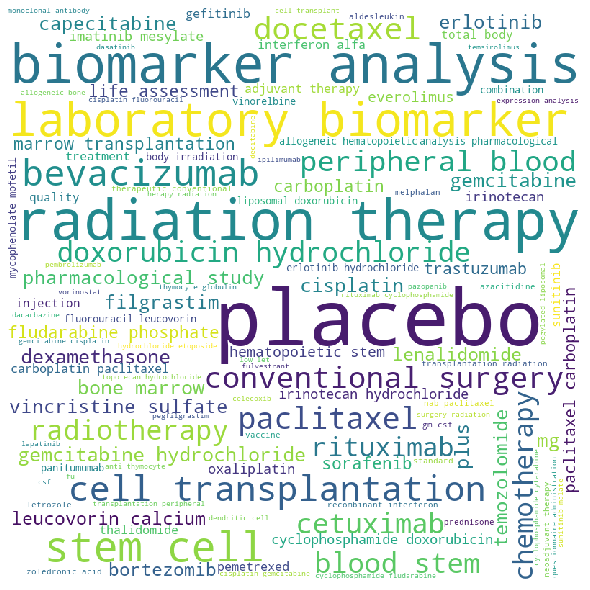

In [63]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(keyword_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [356]:
top_words = ['biomarker', 'stem cell', 'cell transplantation', 'chemotherapy', \
            'radiation/radiotherapy', 'placebo', 'surgery', 'docetaxel', 'bevacizumab', 'doxorubicin', \
             'paclitaxel', 'rituximab', 'cetuximab' ]



In [357]:
top_words_dict={}
for i in top_words:
    if "/" in i:
        j = i.split("/")
        print(j)
        top_words_dict[i] = comp_study_design_info['InterventionName'].apply(lambda x: j[0] in x.lower() or j[1] in x.lower()) 
    else:
        top_words_dict[i] = comp_study_design_info['InterventionName'].apply(lambda x: i in x.lower()) 

['radiation', 'radiotherapy']


In [358]:
top_words_df = pd.DataFrame(top_words_dict)

top_words_df.sum(axis=0)

biomarker                  879
stem cell                  527
cell transplantation       409
chemotherapy               337
radiation/radiotherapy    1516
placebo                   1481
surgery                    576
docetaxel                  866
bevacizumab                763
doxorubicin                652
paclitaxel                1002
rituximab                  558
cetuximab                  345
dtype: int64

In [359]:
comp_study_design_info = pd.concat([comp_study_design_info, top_words_df],axis=1)

In [72]:
keyword_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in comp_study_design_info['InterventionDescription']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = re.split('\|',val)
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    keyword_words += " ".join(tokens)+" "

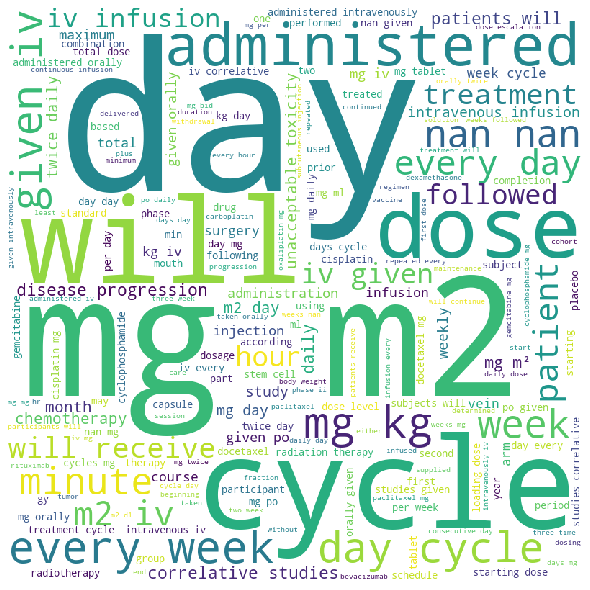

In [73]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(keyword_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [360]:
top_words = ['daily/day', 'weekly/week', 'monthly/month', 'iv/intravenous', 'oral/mouth', \
             'inject/intramuscular', 'correlative studies']

In [361]:
comp_study_design_info['InterventionDescription']=comp_study_design_info['InterventionDescription'].astype(str)

In [362]:
top_words_dict={}
for i in top_words:
    if "/" in i:
        j = i.split("/")
        top_words_dict[i] = comp_study_design_info['InterventionDescription'].apply(lambda x: j[0] in x.lower() or j[1] in x.lower()) 
    else:
        top_words_dict[i] = comp_study_design_info['InterventionDescription'].apply(lambda x: i in x.lower()) 


In [363]:
top_words_df = pd.DataFrame(top_words_dict)

top_words_df.sum(axis=0)

daily/day               6946
weekly/week             3921
monthly/month            769
iv/intravenous          8030
oral/mouth              3195
inject/intramuscular    1102
correlative studies      800
dtype: int64

In [364]:
comp_study_design_info = pd.concat([comp_study_design_info, top_words_df],axis=1)

In [366]:
arms = pd.get_dummies(comp_study_design_info['ArmGroupType'])

In [367]:
comp_study_design_info['ArmGroupType'].value_counts().head(20)

Experimental                                                        7155
Experimental|Experimental                                           1355
Experimental|Active Comparator                                      1305
Experimental|Placebo Comparator                                      787
Active Comparator|Experimental                                       674
Experimental|Experimental|Experimental                               388
Active Comparator|Active Comparator                                  348
Other                                                                227
Experimental|No Intervention                                         223
Experimental|Experimental|Experimental|Experimental                  210
Active Comparator|Placebo Comparator                                 185
Placebo Comparator|Experimental                                      117
Experimental|Experimental|Active Comparator                           98
Experimental|Other                                 

In [368]:
arms['Experimental|Active Comparator'] = arms['Experimental|Active Comparator'] | arms['Active Comparator|Experimental'] 

In [369]:
arms['Experimental|Placebo Comparator'] = arms['Experimental|Placebo Comparator'] | arms['Placebo Comparator|Experimental'] 

In [370]:
arms['Experimental|No Intervention'] = arms['Experimental|No Intervention'] | arms['No Intervention|Experimental'] 

In [371]:
arms['Active Comparator|Placebo Comparator'] = arms['Active Comparator|Placebo Comparator'] | arms['Placebo Comparator|Active Comparator'] 

In [372]:
arms = arms[['Experimental|Active Comparator','Experimental','Experimental|Placebo Comparator', \
            'Experimental|Experimental','Active Comparator|Active Comparator','Experimental|Experimental|Experimental',\
            'Experimental|No Intervention','Active Comparator|Placebo Comparator']]

In [373]:
arms.columns

Index(['Experimental|Active Comparator', 'Experimental',
       'Experimental|Placebo Comparator', 'Experimental|Experimental',
       'Active Comparator|Active Comparator',
       'Experimental|Experimental|Experimental',
       'Experimental|No Intervention', 'Active Comparator|Placebo Comparator'],
      dtype='object')

In [374]:
comp_study_design_info = pd.concat([comp_study_design_info, arms],axis=1)

Calculate number of arms from number of '|' in arms

In [375]:
comp_study_design_info['NumberArms'] = comp_study_design_info['ArmGroupType'].str.count('\|') + 1

In [376]:
comp_study_design_info['NumberArms'].value_counts()

1.0     7436
2.0     5387
3.0      944
4.0      457
5.0      106
6.0       75
7.0       39
8.0       29
9.0       17
10.0       7
12.0       7
11.0       4
15.0       2
17.0       2
13.0       1
14.0       1
Name: NumberArms, dtype: int64

In [377]:
intervents = pd.get_dummies(comp_study_design_info['InterventionType'])

In [378]:
comp_study_design_info['InterventionType'].value_counts().head(10)

Drug                        5389
Drug|Drug                   3457
Drug|Drug|Drug              1395
Drug|Drug|Drug|Drug          580
Biological                   551
Drug|Other                   371
Procedure                    309
Drug|Drug|Drug|Drug|Drug     234
Biological|Drug              227
Biological|Biological        187
Name: InterventionType, dtype: int64

In [379]:
intervents['Drug|Other'] = intervents['Drug|Other'] | intervents['Other|Drug']

In [380]:
intervents['Biological|Drug'] = intervents['Drug|Biological'] | intervents['Biological|Drug']

In [381]:
intervents=intervents[list(comp_study_design_info['InterventionType'].value_counts().head(10).index)]

In [382]:
intervents.columns

Index(['Drug', 'Drug|Drug', 'Drug|Drug|Drug', 'Drug|Drug|Drug|Drug',
       'Biological', 'Drug|Other', 'Procedure', 'Drug|Drug|Drug|Drug|Drug',
       'Biological|Drug', 'Biological|Biological'],
      dtype='object')

In [383]:
comp_study_design_info = pd.concat([comp_study_design_info, intervents],axis=1)

In [384]:
purpose = pd.get_dummies(comp_study_design_info['DesignPrimaryPurpose'])

In [385]:
comp_study_design_info['DesignPrimaryPurpose'].value_counts()

Treatment                          16289
Prevention                           629
Supportive Care                      561
Diagnostic                           363
Other                                 53
Basic Science                         43
Screening                             29
Health Services Research              25
Educational/Counseling/Training        5
Device Feasibility                     1
Name: DesignPrimaryPurpose, dtype: int64

In [386]:
purpose = purpose[['Treatment','Prevention','Supportive Care','Diagnostic']]

In [387]:
comp_study_design_info = pd.concat([comp_study_design_info, purpose],axis=1)

In [388]:
phase = pd.get_dummies(comp_study_design_info['Phase'])

In [389]:
comp_study_design_info = pd.concat([comp_study_design_info, phase],axis=1)

In [390]:
model = pd.get_dummies(comp_study_design_info['DesignInterventionModel'])

In [391]:
comp_study_design_info = pd.concat([comp_study_design_info, model],axis=1)

In [392]:
allocation = pd.get_dummies(comp_study_design_info['DesignAllocation'])

In [393]:
comp_study_design_info = pd.concat([comp_study_design_info, allocation],axis=1)

In [394]:
comp_study_design_info['DesignWhoMasked'].value_counts()

Participant|Care Provider|Investigator|Outcomes Assessor    719
Participant|Investigator                                    689
Participant|Care Provider|Investigator                      314
Participant                                                 134
Participant|Investigator|Outcomes Assessor                  103
Outcomes Assessor                                            99
Investigator                                                 69
Participant|Care Provider                                    36
Participant|Outcomes Assessor                                21
Participant|Care Provider|Outcomes Assessor                  15
Investigator|Outcomes Assessor                               12
Care Provider                                                 6
Care Provider|Investigator|Outcomes Assessor                  4
Care Provider|Investigator                                    1
Name: DesignWhoMasked, dtype: int64

In [395]:
masked = pd.get_dummies(comp_study_design_info['DesignWhoMasked'])

In [396]:
masked = masked[list(comp_study_design_info['DesignWhoMasked'].value_counts().head(5).index)]

In [397]:
comp_study_design_info = pd.concat([comp_study_design_info, masked],axis=1)

In [398]:
comp_study_design_info.shape

(18125, 76)

In [399]:
comp_study_design_info.columns

Index(['Rank', 'NCTId', 'DesignPrimaryPurpose', 'Phase',
       'DesignInterventionModel', 'DesignInterventionModelDescription',
       'DesignWhoMasked', 'DesignAllocation', 'EnrollmentCount',
       'EnrollmentType', 'ArmGroupLabel', 'ArmGroupType',
       'ArmGroupDescription', 'InterventionType', 'InterventionName',
       'InterventionOtherName', 'InterventionDescription', 'biomarker',
       'stem cell', 'cell transplantation', 'chemotherapy',
       'radiation/radiotherapy', 'placebo', 'surgery', 'docetaxel',
       'bevacizumab', 'doxorubicin', 'paclitaxel', 'rituximab', 'cetuximab',
       'daily/day', 'weekly/week', 'monthly/month', 'iv/intravenous',
       'oral/mouth', 'inject/intramuscular', 'correlative studies',
       'Experimental|Active Comparator', 'Experimental',
       'Experimental|Placebo Comparator', 'Experimental|Experimental',
       'Active Comparator|Active Comparator',
       'Experimental|Experimental|Experimental',
       'Experimental|No Intervention', '

In [400]:
comp_study_design_info.to_csv('All_study_design_pandas.csv')

In [125]:
del comp_study_design_info

# Outcomes

In [128]:
comp_outcomes_df = pd.read_csv('All_Outcomes_' + str(1) + '.csv', quotechar='"',skiprows=10,header=0)
for i in range(2,20):
    df = pd.read_csv('All_Outcomes_' + str(i) + '.csv', quotechar='"',skiprows=10,header=0)
    comp_outcomes_df = pd.concat([comp_outcomes_df, df], axis=0, ignore_index=True)

In [343]:
comp_outcomes_df.to_csv('All_Outcomes_combined.csv')

In [129]:
comp_outcomes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18125 entries, 0 to 18124
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Rank                         18125 non-null  int64 
 1   NCTId                        18125 non-null  object
 2   PrimaryOutcomeMeasure        16381 non-null  object
 3   PrimaryOutcomeDescription    10033 non-null  object
 4   PrimaryOutcomeTimeFrame      14824 non-null  object
 5   SecondaryOutcomeMeasure      13874 non-null  object
 6   SecondaryOutcomeDescription  8637 non-null   object
 7   SecondaryOutcomeTimeFrame    12572 non-null  object
 8   OtherOutcomeMeasure          810 non-null    object
 9   OtherOutcomeDescription      650 non-null    object
 10  OtherOutcomeTimeFrame        806 non-null    object
dtypes: int64(1), object(10)
memory usage: 1.5+ MB


In [130]:
comp_outcomes_df['PrimaryOutcomeMeasure']

0                                                      NaN
1                                progression-free survival
2        Prostate biopsy results at Month 6 after treat...
3                                         Overall Survival
4        Recurrence Free Survival Evaluated by Clinical...
                               ...                        
18120    Bioequivalence of 20 mg Ofatumumab Injected by...
18121                                                  NaN
18122    Number of patients developing grade 2 / above ...
18123    Heart rate|Tolerability of common AEs|Pharmaco...
18124    To determine tumor response, overall and progr...
Name: PrimaryOutcomeMeasure, Length: 18125, dtype: object

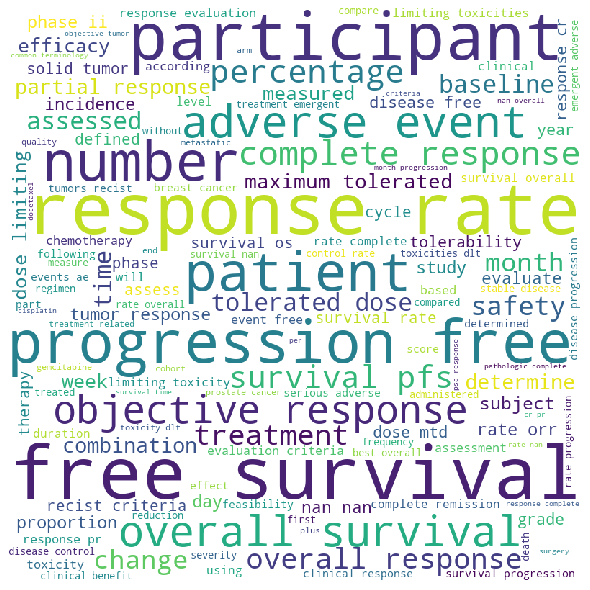

In [129]:
keyword_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in comp_outcomes_df['PrimaryOutcomeMeasure']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = re.split('\|',val)
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    keyword_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(keyword_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [131]:
top_words = ['progression/pfs', 'event free/event-free','disease-free/disease free/dfs/relapse/failure free/rfs/recurrance','adverse event/safet/toxicit/tolera/dose',\
         'overall survival/death/os','response rate/change/reduction/decrease/orr','recist','complete response/remission','quality of life/pain/symptom/morbidity']

In [132]:
comp_outcomes_df['PrimaryOutcomeMeasure']=comp_outcomes_df['PrimaryOutcomeMeasure'].astype(str)

In [133]:
top_words_dict={}
for i in top_words:
    if "/" in i:
        j = i.split("/")
        result= [False]*len(comp_outcomes_df['PrimaryOutcomeMeasure'])
        for k in range(len(j)):
            x = comp_outcomes_df['PrimaryOutcomeMeasure'].apply(lambda x: j[k] in x.lower())
            result = result | x
        top_words_dict[i] = result
    else:
        top_words_dict[i] = comp_outcomes_df['PrimaryOutcomeMeasure'].apply(lambda x: i in x.lower()) 



In [134]:
top_words_df = pd.DataFrame(top_words_dict)

top_words_df.sum(axis=0)


progression/pfs                                                      3016
event free/event-free                                                 235
disease-free/disease free/dfs/relapse/failure free/rfs/recurrance     636
adverse event/safet/toxicit/tolera/dose                              3450
overall survival/death/os                                            4253
response rate/change/reduction/decrease/orr                          3962
recist                                                                766
complete response/remission                                          1231
quality of life/pain/symptom/morbidity                                457
dtype: int64

In [135]:
comp_outcomes_df = pd.concat([comp_outcomes_df, top_words_df],axis=1)

### Use regex to collect all times from PrimaryOutcomeTimeFrame column

In [136]:
comp_outcomes_df['PrimaryOutcomeTimeFrame'].head(20)

0                                                   NaN
1                                              6 months
2                                              6 months
3           From randomization to date last known alive
4     Every 12 weeks up to recurrence or up to 3 mon...
5                                               7 years
6     Within 30 days of surgery|Completion of pre-op...
7                                                   NaN
8                                                   NaN
9                                        Every 36 weeks
10                                            14 months
11                                              2 weeks
12                      Baseline to 4 days post surgery
13                                                  NaN
14    Every 2 cycles of treatment (average 6 weeks) ...
15                                                  NaN
16                                 throughout the study
17                                              

In [138]:
comp_outcomes_df['PrimaryOutcomeTimeFrame']=comp_outcomes_df['PrimaryOutcomeTimeFrame'].astype(str)

In [139]:
reg_ex='(?:[0-9 ]+)?(?:one |two |three |four |five |six |seven |eight |nine |ten |eleven |twelve )?(?:and |to |every )?(?:[0-9]+ )?(?:one |two |three |four |five |six |seven |eight |nine |ten |eleven |twelve )?(?:hr|mo|yr|hour|day|month|year|week)(?: one| two| three| four| five| six| seven| eight| nine| ten| eleven| twelve)?(?: [0-9]+)?(?: and| to)?(?: one| two| three| four| five| six| seven| eight| nine| ten| eleven| twelve)?(?: [0-9]+)?'

In [140]:
prime_times = comp_outcomes_df['PrimaryOutcomeTimeFrame'].apply(lambda x:re.findall(reg_ex, x.lower()))

In [141]:
prime_times[100:150]

100                                            [ 5 year]
101                                                   []
102                                                   []
103                                               [ day]
104                                                   []
105                                              [12 mo]
106                                               [9 mo]
107    [ every 3 mo,  2 year,  every 6 mo, 5 year,  e...
108                                                   []
109                                                   []
110                                                   []
111                                                   []
112                                                   []
113                                                   []
114                                                   []
115                                            [ 5 year]
116                                        [hr,  year 5]
117                            

### Calculate the time in days for the largest value in each list

In [142]:
translation = {'one':'1','two':'2','three':'3','four':'4','five':'5','six':'6','seven':'7',\
              'eight':'8','nine':'9','ten':'10','eleven':'11','twelve':'12'}

prime_max_time=[]
for times in prime_times:
    days=0
    max_time=0
    for time in times:
        if 'year' in time or 'yr' in time:
            try:
                num=re.findall('([0-9]+|one|two|three|four|five|six|seven|eight|nine \
            |ten|eleven|twelve)',time)[-1]
            except IndexError:
                days=365
            if num in translation.keys():
                num=translation[num]
            try:
                days=int(num) * 365
            except:
                days=np.nan
        
        if 'month' in time or 'mo' in time:
            try:
                num=re.findall('([0-9]+|one|two|three|four|five|six|seven|eight|nine \
            |ten|eleven|twelve)',time)[-1]
            except IndexError:
                days=31
            if num in translation.keys():
                num=translation[num]
            try:
                days= int(num) * 31
            except:
                days=np.nan
        
        if 'week' in time:
            try:
                num=re.findall('([0-9]+|one|two|three|four|five|six|seven|eight|nine \
            |ten|eleven|twelve)',time)[-1]
            except IndexError:
                days=7
            if num in translation.keys():
                num=translation[num]
            try:
                days=int(num) * 7
            except:
                days=np.nan
        
        if 'hours' in time or 'hr' in time:
            try:
                num=re.findall('([0-9]+|one|two|three|four|five|six|seven|eight|nine \
            |ten|eleven|twelve)',time)[-1]
            except IndexError:
                days=1/24
            if num in translation.keys():
                num=translation[num]
            try:
                days=int(num) * 1/24
            except:
                days=np.nan
                
        if days in translation.keys():
            days=translation[days]
        try:
            days=int(days) #may need to change to float
        except: 
            days=np.nan
        if days > max_time:
            max_time = days
            
    prime_max_time.append(days)
            
        #change 0 to np.nan
            
            
        

In [143]:
check = pd.DataFrame({'prime_times':prime_times,'prime_max_time_days':prime_max_time})

In [144]:
check[150:200]

,prime_times,prime_max_time_days
150,"[9 mo, 9 mo]",279
151,"[mo, to 24 mo]",744
152,"[hr, 5 year]",1825
153,[3 to 6 mo],186
154,[12 mo],372
155,"[ every 3 mo, 2 year, every 6 mo, 5 year, m...",1825
156,[],0
157,"[ 4 week, 3 day]",28
158,[],0
159,[48 hour],0


In [146]:
check[check['prime_max_time_days']==0] = np.nan

In [147]:
comp_outcomes_df['prim_max_time_days'] = check['prime_max_time_days']

In [149]:
comp_outcomes_df['prim_max_time_days'].isnull().sum()

6186

Length of time lists is number of approximate time points in the study

In [150]:
comp_outcomes_df['approx_num_prim_timepoints'] = prime_times.apply(len)

Calculate number of primary outcome and secondary outcome measures using that fields '|' seperator

In [157]:
number_primary=[]
for i in comp_outcomes_df['PrimaryOutcomeMeasure']:
    if i == 'nan':
        number_primary.append(0)
    else:
        number_primary.append(i.count('|') + 1)

comp_outcomes_df['NumberPrimary'] = number_primary

In [162]:
comp_outcomes_df['SecondaryOutcomeMeasure']=comp_outcomes_df['SecondaryOutcomeMeasure'].astype(str)
number_secondary=[]
for i in comp_outcomes_df['SecondaryOutcomeMeasure']:
    if i == 'nan':
        number_secondary.append(0)
    else:
        number_secondary.append(i.count('|') + 1)

comp_outcomes_df['NumberSecondary'] = number_secondary

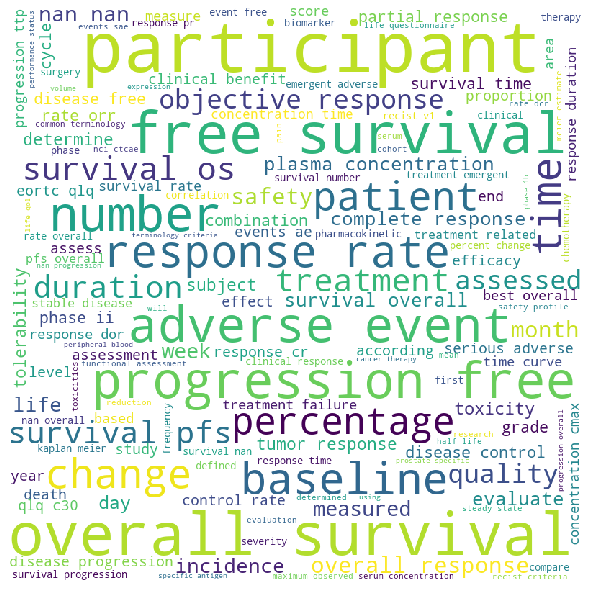

In [154]:
keyword_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in comp_outcomes_df['SecondaryOutcomeMeasure']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = re.split('\|',val)
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    keyword_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(keyword_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [155]:
comp_outcomes_df.shape

(18125, 24)

In [164]:
comp_outcomes_df.columns

Index(['Rank', 'NCTId', 'PrimaryOutcomeMeasure', 'PrimaryOutcomeDescription',
       'PrimaryOutcomeTimeFrame', 'SecondaryOutcomeMeasure',
       'SecondaryOutcomeDescription', 'SecondaryOutcomeTimeFrame',
       'OtherOutcomeMeasure', 'OtherOutcomeDescription',
       'OtherOutcomeTimeFrame', 'progression/pfs', 'event free/event-free',
       'disease-free/disease free/dfs/relapse/failure free/rfs/recurrance',
       'adverse event/safet/toxicit/tolera/dose', 'overall survival/death/os',
       'response rate/change/reduction/decrease/orr', 'recist',
       'complete response/remission', 'quality of life/pain/symptom/morbidity',
       'prim_max_time_days', 'approx_num_prim_timepoints', 'NumberPrimary',
       'NumberSecondary'],
      dtype='object')

In [165]:
comp_outcomes_df.drop(['PrimaryOutcomeMeasure', 'PrimaryOutcomeDescription',
       'PrimaryOutcomeTimeFrame', 'SecondaryOutcomeMeasure',
       'SecondaryOutcomeDescription', 'SecondaryOutcomeTimeFrame',
       'OtherOutcomeMeasure', 'OtherOutcomeDescription',
       'OtherOutcomeTimeFrame'], axis=1, inplace=True )

In [166]:
comp_outcomes_df.to_csv('All_outcomes_pandas.csv')

In [159]:
del comp_outcomes_df

# Eligibility and Investigators

In [6]:
comp_elig_df = pd.read_csv('All_elig_invest_' + str(1) + '.csv', quotechar='"',skiprows=10,header=0)
for i in range(2,20):
    df = pd.read_csv('All_elig_invest_' + str(i) + '.csv', quotechar='"',skiprows=10,header=0)
    comp_elig_df = pd.concat([comp_elig_df, df], axis=0, ignore_index=True)

Split into the the eligibility df and the investigators/sponsors/locations df

In [4]:
comp_invest_df=comp_elig_df.drop(['Gender', 'GenderBased', 'MinimumAge', 'MaximumAge',
       'HealthyVolunteers', 'EligibilityCriteria', 'IPDSharing'],axis=1)
comp_elig_df=comp_elig_df[['Rank', 'NCTId', 'Gender', 'GenderBased', 'MinimumAge', 'MaximumAge',
       'HealthyVolunteers', 'EligibilityCriteria', 'IPDSharing']]


In [352]:
comp_elig_df.to_csv('All_eligibility_combined.csv')
comp_invest_df.to_csv('All_investigators_combined.csv')

In [7]:
comp_elig_df.columns

Index(['Rank', 'NCTId', 'Gender', 'GenderBased', 'MinimumAge', 'MaximumAge',
       'HealthyVolunteers', 'EligibilityCriteria', 'IPDSharing',
       'ResponsiblePartyType', 'ResponsiblePartyInvestigatorAffiliation',
       'LeadSponsorName', 'CollaboratorName', 'OverallOfficialAffiliation',
       'LocationFacility', 'LocationCity', 'LocationState', 'LocationCountry'],
      dtype='object')

In [8]:
comp_elig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18125 entries, 0 to 18124
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Rank                                     18125 non-null  int64 
 1   NCTId                                    18125 non-null  object
 2   Gender                                   18094 non-null  object
 3   GenderBased                              74 non-null     object
 4   MinimumAge                               16864 non-null  object
 5   MaximumAge                               5083 non-null   object
 6   HealthyVolunteers                        18072 non-null  object
 7   EligibilityCriteria                      18119 non-null  object
 8   IPDSharing                               2422 non-null   object
 9   ResponsiblePartyType                     14652 non-null  object
 10  ResponsiblePartyInvestigatorAffiliation  3040 non-null   o

In [9]:
comp_elig_df['Gender'].value_counts()

All       14235
Female     2633
Male       1226
Name: Gender, dtype: int64

In [10]:
gend = pd.get_dummies(comp_elig_df['Gender'])
comp_elig_df = pd.concat([comp_elig_df, gend], axis=1)

Convert max and min ages to days for all to be on the same scale

In [11]:
comp_elig_df['MaximumAge']=comp_elig_df['MaximumAge'].astype(str)

In [13]:
import re

In [37]:
max_age_days=[]
for age in comp_elig_df['MaximumAge']:
    if 'Year' in age:
        max_age_days.append(float(re.findall('[0-9]+',age)[0])*365)
    elif 'Month' in age:
        max_age_days.append(float(re.findall('[0-9]+',age)[0])*31)
    elif 'Week' in age:
        max_age_days.append(float(re.findall('[0-9]+',age)[0])*7)
    elif 'Day' in age:
        max_age_days.append(float(re.findall('[0-9]+',age)[0])*1)
    elif 'Hour' in age:
        max_age_days.append(float(re.findall('[0-9]+',age)[0])*1/24)
    else:
        max_age_days.append(100)

In [40]:
comp_elig_df['max_age_days'] = max_age_days

In [41]:
comp_elig_df['MinimumAge']=comp_elig_df['MinimumAge'].astype(str)

In [42]:
min_age_days=[]
for age in comp_elig_df['MinimumAge']:
    if 'Year' in age:
        min_age_days.append(float(re.findall('[0-9]+',age)[0])*365)
    elif 'Month' in age:
        min_age_days.append(float(re.findall('[0-9]+',age)[0])*31)
    elif 'Week' in age:
        min_age_days.append(float(re.findall('[0-9]+',age)[0])*7)
    elif 'Day' in age:
        min_age_days.append(float(re.findall('[0-9]+',age)[0])*1)
    elif 'Hour' in age:
        min_age_days.append(float(re.findall('[0-9]+',age)[0])*1/24)
    else:
        min_age_days.append(0)

In [43]:
comp_elig_df['min_age_days'] = min_age_days

In [45]:
comp_elig_df['HealthyVolunteers'].value_counts()

No                            17739
Accepts Healthy Volunteers      333
Name: HealthyVolunteers, dtype: int64

### Eligability Criteria can be split into Inclusion and Exclusion section

In [46]:
comp_elig_df['EligibilityCriteria']=comp_elig_df['EligibilityCriteria'].astype(str)

In [51]:
comp_elig_df['EligibilityCriteria'][10]

'Inclusion Criteria:||confirmed diagnosis of NSCLC|Stage IIIB or IV NSCLC|ECOG Performance Status 0 or 1|Prior therapy defined as 1 prior systemic therapy for advanced disease|measurable disease|Radiologic evidence of disease progression following most recent prior treatment.|Adequate hematologic, hepatic, renal function||Exclusion Criteria:||Active or untreated CNS metastases|Active malignancies other than NSCLC within the last 5 years with the exception of adequately treated cone-biopsied in situ carcinoma of the cervix uteri or basal or squamous cell carcinoma of the skin|Serious cardiac illness or medical conditions|Pregnant or lactating women|Uncontrolled intercurrent illness'

In [48]:
Inclusion = comp_elig_df['EligibilityCriteria'].apply(lambda x: x.split('||Exclusion Criteria'))

In [49]:
inc = []
for row in Inclusion:
    try:
        inc.append(row[0])
    except:
        inc.append(0)

In [50]:
exc = []
for row in Inclusion:
    try:
        exc.append(row[1])
    except:
        exc.append(0)

In [52]:
inc[10]

'Inclusion Criteria:||confirmed diagnosis of NSCLC|Stage IIIB or IV NSCLC|ECOG Performance Status 0 or 1|Prior therapy defined as 1 prior systemic therapy for advanced disease|measurable disease|Radiologic evidence of disease progression following most recent prior treatment.|Adequate hematologic, hepatic, renal function'

In [53]:
exc[10]

':||Active or untreated CNS metastases|Active malignancies other than NSCLC within the last 5 years with the exception of adequately treated cone-biopsied in situ carcinoma of the cervix uteri or basal or squamous cell carcinoma of the skin|Serious cardiac illness or medical conditions|Pregnant or lactating women|Uncontrolled intercurrent illness'

In [57]:
num_inc=[]
for i in inc:
    i=str(i)
    num_inc.append(i.count('|')-1)

comp_elig_df['number_incl_crit'] = num_inc

num_exc=[]
for i in exc:
    i=str(i)
    num_exc.append(i.count('|'))
    
comp_elig_df['number_excl_crit'] = num_exc

In [61]:
comp_elig_df['number_excl_crit'].value_counts()

0      5464
6       915
8       765
5       764
7       757
       ... 
69        1
106       1
132       1
93        1
111       1
Name: number_excl_crit, Length: 76, dtype: int64

In [62]:
comp_elig_df['number_incl_crit'].value_counts()

3      1521
5      1065
4       913
6       886
7       880
       ... 
132       1
179       1
163       1
194       1
0         1
Name: number_incl_crit, Length: 156, dtype: int64

Top words were made based on looking at several of the eligibility entries and domain knowledge

In [63]:
top_words = ['biopsy/histolog', 'ecog/who performance', 'resectable', 'vitamin', \
 'hypertension/blood pressure', 'life expectancy', 'scan/imaging/tomography', \
 'hemoglobin','diabetes/glucose', 'AST/ALT/liver', 'creatinine/renal',\
 'medication', 'conditions', 'allergy/sensitivity', 'metasta', 'lymph', 'heart/myocard/ventric', \
 'previously untreated/no prior treatment', 'radiation/radiotherapy', 'chemo', 'infection', 'contraception', \
 'surgery']

In [64]:
top_words_dict={}
for i in top_words:
    if "/" in i:
        j = i.split("/")
        result= [False]*len(comp_elig_df['EligibilityCriteria'])
        for k in range(len(j)):
            x = comp_elig_df['EligibilityCriteria'].apply(lambda x: j[k] in x.lower())
            result = result | x
        top_words_dict[i] = result
    else:
        top_words_dict[i] = comp_elig_df['EligibilityCriteria'].apply(lambda x: i in x.lower()) 

In [65]:
top_words_df = pd.DataFrame(top_words_dict)

In [66]:
top_words_df.sum(axis=0)

biopsy/histolog                            11345
ecog/who performance                        9172
resectable                                  1965
vitamin                                      688
hypertension/blood pressure                 3760
life expectancy                             6588
scan/imaging/tomography                     5126
hemoglobin                                  4367
diabetes/glucose                            2298
AST/ALT/liver                               5397
creatinine/renal                           12097
medication                                  4686
conditions                                  2806
allergy/sensitivity                         5585
metasta                                     9699
lymph                                       3980
heart/myocard/ventric                       8095
previously untreated/no prior treatment      779
radiation/radiotherapy                     11140
chemo                                      12445
infection           

In [67]:
comp_elig_df = pd.concat([comp_elig_df,top_words_df],axis=1)

In [71]:
comp_elig_df.shape

(18125, 48)

In [72]:
comp_elig_df.columns

Index(['Rank', 'NCTId', 'Gender', 'GenderBased', 'MinimumAge', 'MaximumAge',
       'HealthyVolunteers', 'EligibilityCriteria', 'IPDSharing',
       'ResponsiblePartyType', 'ResponsiblePartyInvestigatorAffiliation',
       'LeadSponsorName', 'CollaboratorName', 'OverallOfficialAffiliation',
       'LocationFacility', 'LocationCity', 'LocationState', 'LocationCountry',
       'All', 'Female', 'Male', 'max_age_days', 'min_age_days',
       'number_incl_crit', 'number_excl_crit', 'biopsy/histolog',
       'ecog/who performance', 'resectable', 'vitamin',
       'hypertension/blood pressure', 'life expectancy',
       'scan/imaging/tomography', 'hemoglobin', 'diabetes/glucose',
       'AST/ALT/liver', 'creatinine/renal', 'medication', 'conditions',
       'allergy/sensitivity', 'metasta', 'lymph', 'heart/myocard/ventric',
       'previously untreated/no prior treatment', 'radiation/radiotherapy',
       'chemo', 'infection', 'contraception', 'surgery'],
      dtype='object')

In [73]:
IPD=pd.get_dummies(comp_elig_df['IPDSharing'], prefix="IPD")
comp_elig_df = pd.concat([comp_elig_df, IPD],axis=1)

## Investigators and sponsors and locations data frame 

In [78]:
comp_invest_df['ResponsiblePartyType'].value_counts()

Sponsor                   11612
Principal Investigator     2407
Sponsor-Investigator        633
Name: ResponsiblePartyType, dtype: int64

In [79]:
party_type=pd.get_dummies(comp_invest_df['ResponsiblePartyType'],prefix='party')

comp_invest_df=pd.concat([comp_invest_df,party_type],axis=1)

In [80]:
comp_invest_df['LeadSponsorName'].value_counts().head(10)

National Cancer Institute (NCI)                                       1174
M.D. Anderson Cancer Center                                            565
Memorial Sloan Kettering Cancer Center                                 347
Novartis Pharmaceuticals                                               313
Eli Lilly and Company                                                  299
Hoffmann-La Roche                                                      294
Alliance for Clinical Trials in Oncology                               290
Pfizer                                                                 212
Amgen                                                                  189
European Organisation for Research and Treatment of Cancer - EORTC     177
Name: LeadSponsorName, dtype: int64

In [81]:
sponsor_name = pd.get_dummies(comp_invest_df['LeadSponsorName'],prefix="sponsor")
top_sponsor=[]
for i in list(comp_invest_df['LeadSponsorName'].value_counts().head(10).index):
    top_sponsor.append('sponsor_'+i)
sponsor_name = sponsor_name[top_sponsor]
comp_invest_df=pd.concat([comp_invest_df,sponsor_name],axis=1)

Count Collaborators with '|' in this field

In [82]:
comp_invest_df['CollaboratorName']=comp_invest_df['CollaboratorName'].astype(str)

In [77]:
comp_invest_df['CollaboratorName']

0                                        NaN
1                                        NaN
2                                        NaN
3                                        NaN
4                                        NaN
                        ...                 
18120                                    NaN
18121                                    NaN
18122                                    NaN
18123    United States Department of Defense
18124                    Celgene Corporation
Name: CollaboratorName, Length: 18125, dtype: object

In [98]:
collab_count =[]
for i in comp_invest_df['CollaboratorName']:
    if i == 'nan':
        collab_count.append(0)
    else:
        collab_count.append(i.count('|') + 1)

In [100]:
comp_invest_df['collab_count'] = collab_count

In [101]:
comp_invest_df['collab_count'].value_counts()

0     10421
1      5841
2      1144
3       354
4       149
5        79
6        48
7        24
9        15
10       13
8        12
11        7
13        4
14        4
12        3
19        2
23        1
29        1
27        1
17        1
16        1
Name: collab_count, dtype: int64

In [104]:
comp_invest_df['OverallOfficialAffiliation'].value_counts().head(10)

M.D. Anderson Cancer Center               589
Memorial Sloan Kettering Cancer Center    390
Mayo Clinic                               315
Hoffmann-La Roche                         294
Novartis Pharmaceuticals                  280
Eli Lilly and Company                     277
Dana-Farber Cancer Institute              223
National Cancer Institute (NCI)           212
Amgen                                     207
Pfizer                                    195
Name: OverallOfficialAffiliation, dtype: int64

In [105]:
official = pd.get_dummies(comp_invest_df['OverallOfficialAffiliation'],prefix="official")
top_officials=[]
for i in list(comp_invest_df['OverallOfficialAffiliation'].value_counts().head(10).index):
    top_officials.append('official_'+i)
official = official[top_officials]
comp_invest_df=pd.concat([comp_invest_df,official],axis=1)

In [106]:
comp_invest_df.columns

Index(['Rank', 'NCTId', 'Gender', 'GenderBased', 'MinimumAge', 'MaximumAge',
       'HealthyVolunteers', 'EligibilityCriteria', 'IPDSharing',
       'ResponsiblePartyType', 'ResponsiblePartyInvestigatorAffiliation',
       'LeadSponsorName', 'CollaboratorName', 'OverallOfficialAffiliation',
       'LocationFacility', 'LocationCity', 'LocationState', 'LocationCountry',
       'All', 'Female', 'Male', 'max_age_days', 'min_age_days',
       'number_incl_crit', 'number_excl_crit', 'biopsy/histolog',
       'ecog/who performance', 'resectable', 'vitamin',
       'hypertension/blood pressure', 'life expectancy',
       'scan/imaging/tomography', 'hemoglobin', 'diabetes/glucose',
       'AST/ALT/liver', 'creatinine/renal', 'medication', 'conditions',
       'allergy/sensitivity', 'metasta', 'lymph', 'heart/myocard/ventric',
       'previously untreated/no prior treatment', 'radiation/radiotherapy',
       'chemo', 'infection', 'contraception', 'surgery', 'IPD_No',
       'IPD_Undecided', 'IPD

In [108]:
comp_invest_df['location_count'] = comp_invest_df['LocationFacility'].str.count('\|') + 1

In [109]:
comp_invest_df['location_count'].value_counts()

1.0      7707
2.0      1152
3.0       701
4.0       506
5.0       415
         ... 
524.0       1
623.0       1
290.0       1
247.0       1
682.0       1
Name: location_count, Length: 350, dtype: int64

In [110]:
n_countries=[]
for i in comp_invest_df['LocationCountry'].str.split('\|'):
    try:
        n_countries.append(len(set(i)))
    except:
        n_countries.append(0)

In [111]:
comp_invest_df['num_countries'] = n_countries

Find the country that makes up the largest percentage of the sites in each study

In [246]:
from collections import Counter
mode_countries=[]
for i in comp_invest_df['LocationCountry']:
    try:
        i=i.split('|')
        i=Counter(i)
        mode=i.most_common(1)[0][0]
        mode_countries.append(mode)
    except:
        n_countries.append(0)

In [251]:
pd.Series(mode_countries).value_counts().head(50)

United States                10562
France                         904
Germany                        687
Canada                         574
China                          558
Italy                          465
United Kingdom                 417
Korea, Republic of             398
Japan                          349
Spain                          304
Netherlands                    188
Belgium                        176
Denmark                        136
Switzerland                    127
Taiwan                         118
Australia                      108
Russian Federation             102
Austria                         95
Brazil                          93
Greece                          74
Sweden                          74
India                           66
Israel                          56
Norway                          49
Singapore                       41
Poland                          38
Finland                         37
Hong Kong                       30
Egypt               

Ulitmately decided to make binary columns for several countries with a large number of trials

In [112]:
top_words=['United States', 'China', 'France', 'Germany', 'Canada', \
          'Japan', 'Italy', 'Korea', 'Spain', 'Netherlands', 'Russian' \
          ,'India', 'Switzerland', 'Belgium', 'Brazil', 'Egypt', 'Greece', 'Australia', \
          'Denmark', 'Sweden', 'Taiwan', 'Singapore', 'Austria', 'Israel', 'Norway', 'Poland', \
          'Finland', 'Hong Kong', 'Turkey', 'Mexico', 'Argentina', 'Ireland', 'Thailand']

comp_invest_df['LocationCountry']=comp_invest_df['LocationCountry'].astype('str')

top_words_dict={}
for i in top_words:
    top_words_dict[i] = comp_invest_df['LocationCountry'].apply(lambda x: i in x) 

In [113]:
top_words_df = pd.DataFrame(top_words_dict)

In [114]:
top_words_df.sum(axis=0)

United States    10944
China              749
France            2016
Germany           1790
Canada            1971
Japan              562
Italy             1564
Korea              933
Spain             1473
Netherlands        900
Russian            646
India              274
Switzerland        566
Belgium           1150
Brazil             465
Egypt               96
Greece             375
Australia          920
Denmark            435
Sweden             484
Taiwan             527
Singapore          285
Austria            619
Israel             469
Norway             261
Poland             796
Finland            242
Hong Kong          268
Turkey             254
Mexico             289
Argentina          332
Ireland            211
Thailand           211
dtype: int64

In [115]:
comp_invest_df = pd.concat([comp_invest_df,top_words_df],axis=1)
comp_invest_df.shape

(18125, 110)

Use the top 100 location cities as features

In [116]:
comp_invest_df['LocationCity']=comp_invest_df['LocationCity'].astype(str)
whole_list=[]
for i in comp_invest_df['LocationCity']:
    i=i.split('|')
    for j in i:
        whole_list.append(j)
pd.Series(whole_list).value_counts()


New York              3343
Boston                2968
Chicago               2963
Houston               2695
Seattle               2477
                      ... 
Bordeaux, 33             1
Collonge-Bellerive       1
Kollkata                 1
Saint Catherines         1
Winton                   1
Length: 11038, dtype: int64

In [117]:
pd.Series(whole_list).value_counts().head(100)

New York       3343
Boston         2968
Chicago        2963
Houston        2695
Seattle        2477
               ... 
Lyon            615
Hamburg         612
La Jolla        607
Missoula        606
Chapel Hill     596
Length: 100, dtype: int64

In [118]:
top_words=list(pd.Series(whole_list).value_counts().head(100).index)


top_words_dict={}
for i in top_words:
    top_words_dict[i] = comp_invest_df['LocationCity'].apply(lambda x: i in x) 


top_words_df = pd.DataFrame(top_words_dict)

comp_invest_df = pd.concat([comp_invest_df,top_words_df],axis=1)



In [119]:
comp_invest_df.shape

(18125, 210)

Use the top 100 location facilities as features

In [120]:
comp_invest_df['LocationFacility']=comp_invest_df['LocationFacility'].astype(str)
whole_list=[]
for i in comp_invest_df['LocationFacility']:
    i=i.split('|')
    for j in i:
        whole_list.append(j)
pd.Series(whole_list).value_counts()



Research Site                                                         14992
Novartis Investigative Site                                           11285
GSK Investigational Site                                               6718
Pfizer Investigational Site                                            6273
Local Institution                                                      4263
                                                                      ...  
US Oncology Albany, New York Oncology                                     1
Retina Health Center                                                      1
Miami Cancer Institute, Baptist Health South Florida                      1
Azienda Sanitaria Ospedaliera "San Luigi Gonzaga"                         1
Casa de Saude Santa Marcelina (Centro de Pesquisa Santa Marcelina)        1
Length: 63501, dtype: int64

In [121]:
pd.Series(whole_list).value_counts().head(100)

Research Site                                            14992
Novartis Investigative Site                              11285
GSK Investigational Site                                  6718
Pfizer Investigational Site                               6273
Local Institution                                         4263
                                                         ...  
CancerCare Manitoba                                        166
Medical College of Wisconsin                               164
M D Anderson Cancer Center                                 164
Lineberger Comprehensive Cancer Center, UNC                164
Comprehensive Cancer Center at Wake Forest University      162
Length: 100, dtype: int64

In [122]:
top_words=list(pd.Series(whole_list).value_counts().head(100).index)


top_words_dict={}
for i in top_words:
    top_words_dict[i] = comp_invest_df['LocationCity'].apply(lambda x: i in x) 


top_words_df = pd.DataFrame(top_words_dict)

comp_invest_df = pd.concat([comp_invest_df,top_words_df],axis=1)

In [123]:
comp_invest_df.columns

Index(['Rank', 'NCTId', 'Gender', 'GenderBased', 'MinimumAge', 'MaximumAge',
       'HealthyVolunteers', 'EligibilityCriteria', 'IPDSharing',
       'ResponsiblePartyType',
       ...
       'University of Wisconsin Comprehensive Cancer Center',
       'Samsung Medical Center', 'Tennessee Oncology, PLLC',
       'Memorial Hospital of South Bend',
       'CCOP - Southeast Cancer Control Consortium', 'CancerCare Manitoba',
       'Medical College of Wisconsin', 'M D Anderson Cancer Center',
       'Lineberger Comprehensive Cancer Center, UNC',
       'Comprehensive Cancer Center at Wake Forest University'],
      dtype='object', length=310)

In [126]:
comp_elig_df.to_csv('All_elig_df_pandas.csv')

In [127]:
comp_invest_df.to_csv('All_invest_df_pandas.csv')

In [281]:
del comp_elig_df, comp_invest_df